## load data + cleaning

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

In [2]:

def first_aid(df):
    temp = 'data/'+df+'.csv'
    df = pd.read_csv(temp , sep =',', names = list(range(0,30)))
    df = df[[4,0,5,1,2,3]+list(range(6,29))]
    df[5] = df[5].map(lambda x: x.lstrip('מספר תגובות -'))
    df.columns = ['url','data','number_comment','name','title',1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]
    return df

joy = first_aid('pain')
bowel_diseases = first_aid('bowel_diseases')
joints = first_aid('joints')
psoriasis = first_aid('psoriasis')
sclerosis = first_aid('sclerosis')



## organize data + future engineer
### Collect names in one column

In [3]:
def isNaN(num):
    #check if isNaN
    return num != num
def extract_name(dat,i,j):
    #get a cell, and extracts the name and response
    if not isinstance(dat,str):
        print('Mistake at point'+ str(i)+' ' + str(j) + 'Does not send string')
        return ['','']
    x1 = dat.find('XX')
    x2 = dat.rfind('XX')
    if x1 or x2 <0:
        print("Can't find Name"+ str(i) + "," + str(j))
        return['','']
    name = dat[x1+2:x2]
    text = dat[x2+2:]
    if len(name) > 30:
        print("Can't extract Name"+ str(i) + "," + str(j))
        return ['','']
    return [name,text]

def listToString(s):
    str1 = ""
    for ele in s:
        str1 += ele
        str1 += ","
    return str1
def organize_name(df):
    #Gets DF and deletes the responses from the names and centers them in one cell
    dim = df.shape
    for i in range(0,dim[0]):
        name = [df.loc[i,'name']]
        for j in range(6,dim[1]):
            dat = df.iloc[i,j]
            if not isNaN(dat):
                save_cell = extract_name(dat,i,j)
                df.iloc[i,j] = save_cell[1]
                name.append(save_cell[0])
            else:
                break
        df.loc[i,'name'] = listToString(name)
    return df
joy = organize_name(joy)
#bowel_diseases = organize_name(bowel_diseases)
#joints = organize_name(joints)
#psoriasis = organize_name(psoriasis)
#sclerosis = organize_name(sclerosis)

joy1 = joy.copy()

Can't extract Name121,9
Can't extract Name361,11


### clean the text

In [4]:
import itertools

def delete_prefixes(item,prefixes_word):
    #Deleting section. Gets two words (in list) and deletes everything in between 
    #Example for the need can be find at joy.iloc[13,5]
    for word in prefixes_word:
        loc1 = item.find(word[0])
        loc2 = item.find(word[1])
        #print(loc1,loc2)
        while loc1 > 0 and loc2 > 0:
            length_w = len(word[1])
            item = item[:loc1] + item[loc2+length_w:]
            loc1 = item.find(word[0])
            loc2 = item.find(word[1])
    return item



def delete_word(item,delete_list):
    # delete words form the cell
    for word in delete_list:
        if word in item:
            loc = item.find(word)
            while loc > 0:
                length_w = len(word)
                item = item[:loc] + item[loc+length_w:]
                loc = item.find(word)
    return item

def multi_option_delete(item,multi_option):
    #Like delete_prefixes but for multiple selection.
    prefixes_word = list(itertools.product(*multi_option))
    item = delete_prefixes(item,prefixes_word)
    return item

def regex_remove(item,list_ex):
    for reg in list_ex:
        pattern = re.compile(reg)
        item = pattern.sub('', item)
    return item

def clean_df(item):
    #get cell and list of word that not allowed to be contain in the cell
    #return the cell clean
    list_regex = ['\S*@\S*\s?','http\S+']
    #list reg  = email         , web
    prefixes_word = [['<a','a>'],['<br >','<br>'],['<div','div>']]
    delete_list = ['&nbsp;','&quot;']
    #multi_option = [['http','https'],['co.il','com']]
    if isNaN(item):
        return item
    item = delete_word(item,delete_list)
    item = delete_prefixes(item,prefixes_word)
    #item = multi_option_delete(item,multi_option)
    item = regex_remove(item,list_regex)
    return item






def run_over_DF(df,fun):
#Unfortunately applymap run to MemoryError: in some case. This function overcomes this obstacle
    dim = df.shape
    for i in range(0,dim[0]):
    #for i in range(0,1000):
        if i % 100 == 0:
            print('#',i)
        for j in range(4,dim[1]):
            dat = fun(df.iloc[i,j])
            df.iloc[i,j] = dat
    return df
joy = run_over_DF(joy,clean_df)

#bowel_diseases = bowel_diseases.applymap(clean_df)
#joints = joints.applymap(clean_df)
#psoriasis = psoriasis.applymap(clean_df)
#sclerosis = sclerosis.applymap(clean_df)

# 0
# 100
# 200
# 300
# 400
# 500
# 600
# 700
# 800
# 900
# 1000
# 1100
# 1200
# 1300


## Visualization data

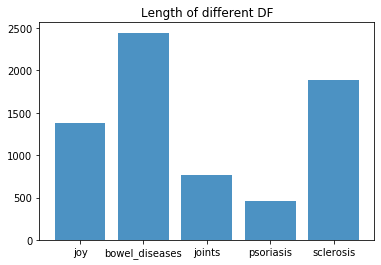

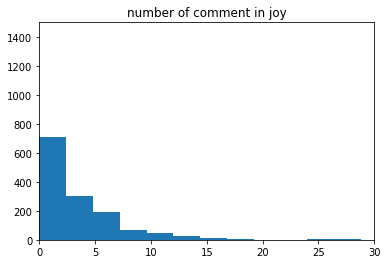

In [5]:
table = [joy,bowel_diseases,joints,psoriasis,sclerosis]
x = []
for df in table:
    x.append(df.shape[0])
y=['joy','bowel_diseases','joints','psoriasis','sclerosis']
plt.bar(y, x, align='center', alpha=0.8)
plt.title("Length of different DF")
plt.show()

def hist_comment(df,name_DF):
    save = df['number_comment'].tolist()
    save = list(map(int, save))
    plt.hist(save,bins=30)
    plt.axis([0, 30, 0, 1500])
    plt.title('number of comment in '+name_DF)
    plt.show()
    # TODO: Can you make the graph look prettier? I get in trouble with that
#hist_comment(psoriasis)
hist_comment(joy,'joy')

In [92]:
def split_DF_to_word(df):
    #Gets DF and returns a list of the words from all columns and rows
    #Preparing to graph: plot_20_common
    dim = df.shape
    all_words = []
    for i in range(0,dim[0]):
        if i % 100 == 0:
            print('#',i)
        for j in range(4,dim[1]):
            dat = df.iloc[i,j]
            if not isNaN(dat):
                temp = dat.split()
                all_words = all_words + temp
            else:
                break
    return all_words



#joy.iloc[0,5] = 'hello hi '*10000 
temp = split_DF_to_word(joy)



# 0
# 100
# 200
# 300
# 400
# 500
# 600
# 700
# 800
# 900
# 1000
# 1100
# 1200
# 1300


In [93]:
print( 'hello hi '*2)
temp = 'hello hi '*2
temp.split()

hello hi hello hi 


['hello', 'hi', 'hello', 'hi']

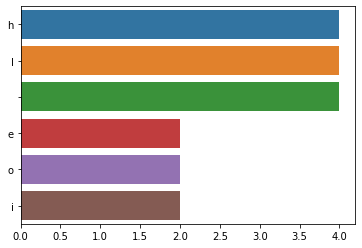

In [94]:
def invert_words(words):
    #Reverses the direction of the words so that the graphs in Hebrew will be readable
    return [w[::-1] for w in words]

def plot_20_common(words):
    #Gets text divided into tokens, pulls out a graph
    word_count = Counter(words)
    most=word_count.most_common(20)
    x, y= zip(*most)
    sns.barplot(x=y,y=invert_words(x))

plot_20_common(temp)

In [95]:
def plot_top_ngrams_barchart(text, n=2):
    vec = CountVectorizer(ngram_range=(n, n)).fit(text)
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    words_freq = words_freq[:10]
    x,y=map(list,zip(*words_freq))
    sns.barplot(x=y,y=invert_words(x))

plot_top_ngrams_barchart(temp,n=2)
#TODO: well, do you know how to make a graph, not to be one on another?


ValueError: Iterable over raw text documents expected, string object received.

In [96]:
#print(joy.iloc[210,5])
print('##')
#print(joy1.iloc[210,5])
print (joy[joy[1].str.contains('39', na=False)])


##
                                         url        data number_comment  \
6     https://www.camoni.co.il/411804/121858  14/01/2015              2   
48    https://www.camoni.co.il/411804/123105  28/03/2015             10   
89    https://www.camoni.co.il/411804/124469  03/06/2015             17   
112   https://www.camoni.co.il/411804/125368  25/07/2015              4   
148   https://www.camoni.co.il/411804/126769  07/10/2015              1   
151   https://www.camoni.co.il/411804/126920  16/10/2015              2   
209   https://www.camoni.co.il/411804/128585  11/01/2016              5   
210   https://www.camoni.co.il/411804/128638  14/01/2016              0   
262   https://www.camoni.co.il/411804/130111  01/04/2016              2   
309   https://www.camoni.co.il/411804/131308  09/06/2016              9   
483   https://www.camoni.co.il/411804/135523  06/02/2017             72   
489   https://www.camoni.co.il/411804/135635  12/02/2017              1   
637   https://www.camo

### Functions for the future

In [97]:
def return_phd(cell):
#Looking in the comments who of the writers is a PhD
#return
    cell = cell.split(',')
    save = []
    for i,name in enumerate(cell):
        temp = re.sub(r'[^\w]', ' ', name)
        if "ד ר" in temp or "PhD" in temp:
            save.append(i)
            print(i)
    return save

